In [1]:
from pathlib import Path
import torch
import torch.nn as nn
from config import get_config, get_weights_file_path
from train import get_model, get_ds, run_validation

import matplotlib.pyplot as plt

In [43]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
cfg = get_config()

cfg['data_pickle_name'] = "synth_data.pkl"

cfg['batch_size'] = 24
cfg['num_epochs'] = 600
cfg['lr'] = 10**-6
cfg['tgt_seq_len'] = 12

cfg['d_model'] = 24
cfg['d_ff'] = 64
cfg['model_folder'] = 'test_w'
cfg['preload'] = f'299'
cfg['experiment_name'] = 'test/tmodel'

train_dataloader, val_dataloader, test_dataloader, scaler, train_dataloader_ob = get_ds(cfg)
model = get_model(cfg).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(cfg, f"449")
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])

Using device: cpu
[]


<All keys matched successfully>

In [46]:
loss, ground_truth, predicted, src_input = run_validation(model, test_dataloader, scaler, device, lambda msg: print(msg), 0, None, 0)

100%|██████████| 49/49 [00:04<00:00, 10.75it/s]

Validation loss of epoch 0: 0.017825989052653313


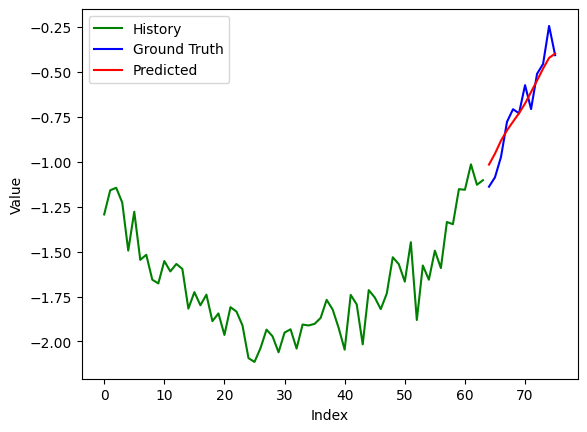

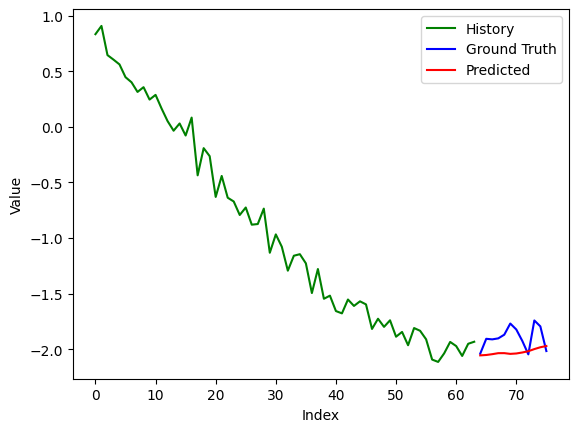

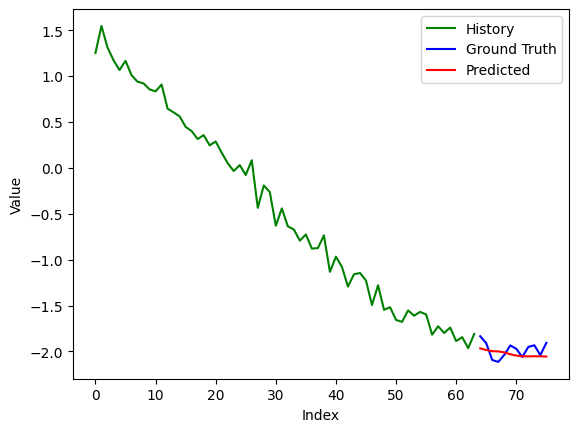

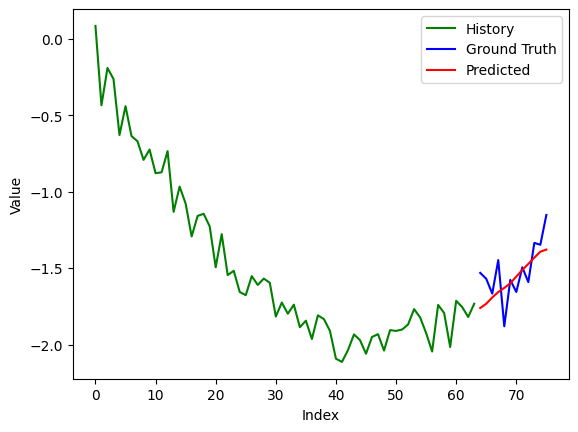

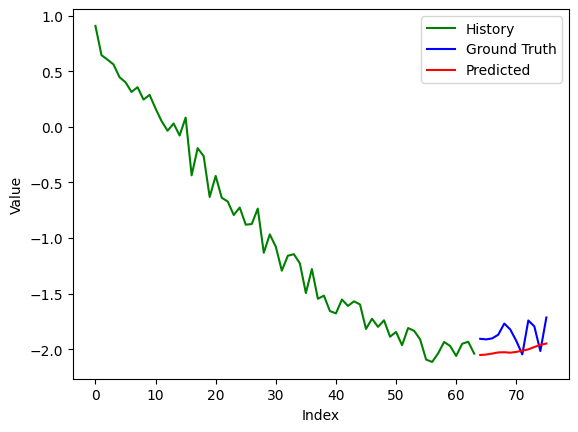

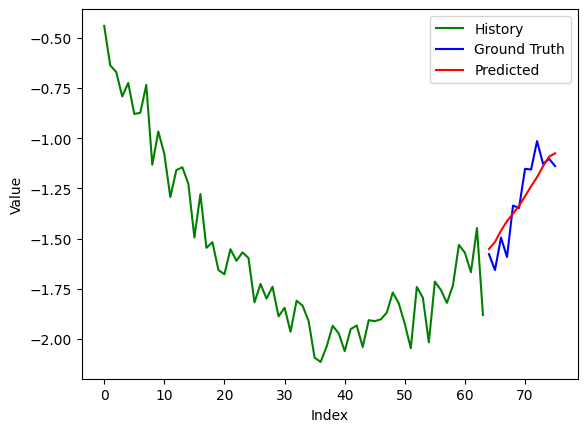

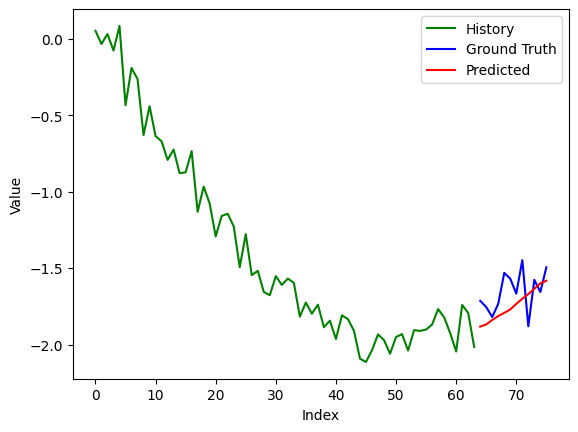

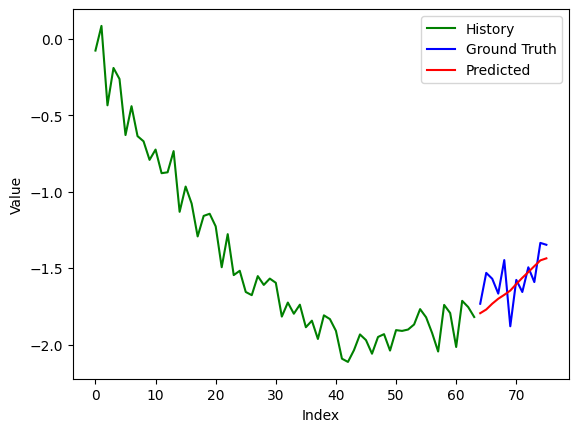

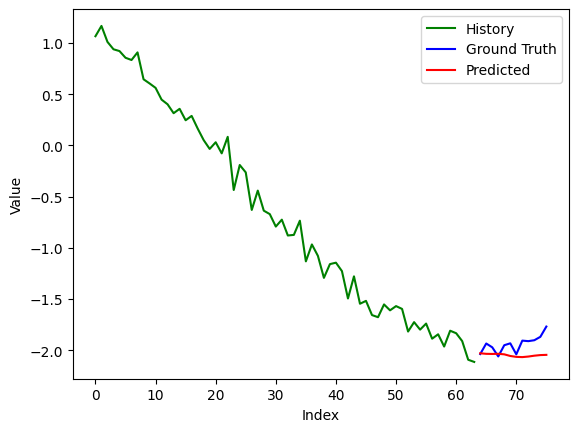

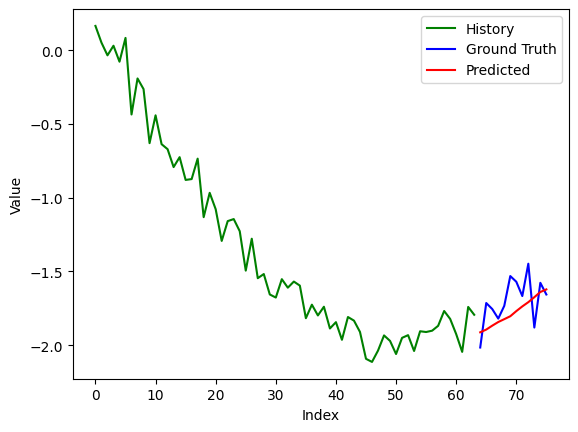

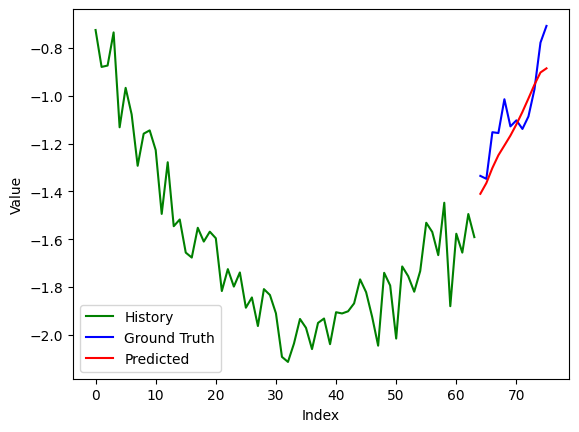

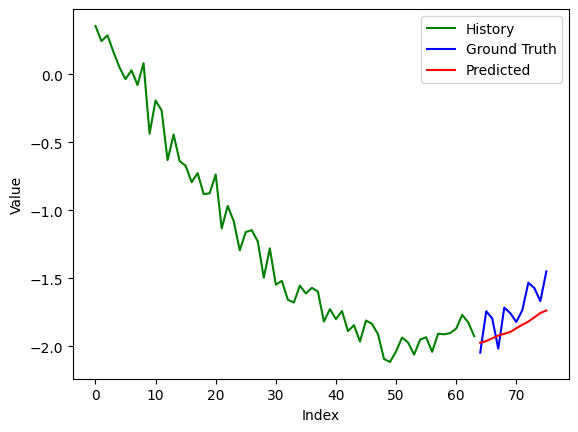

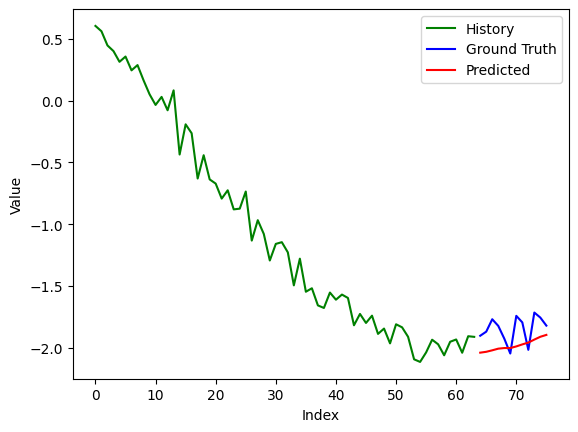

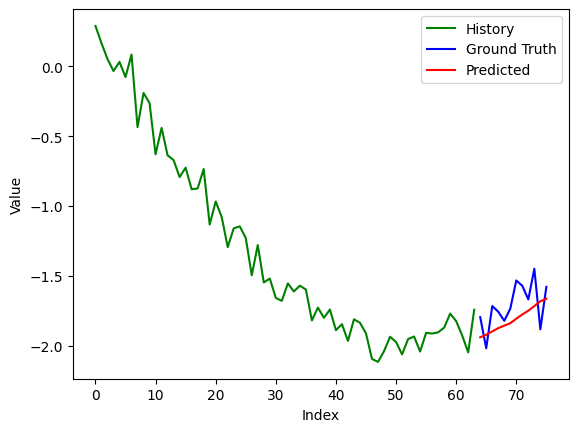

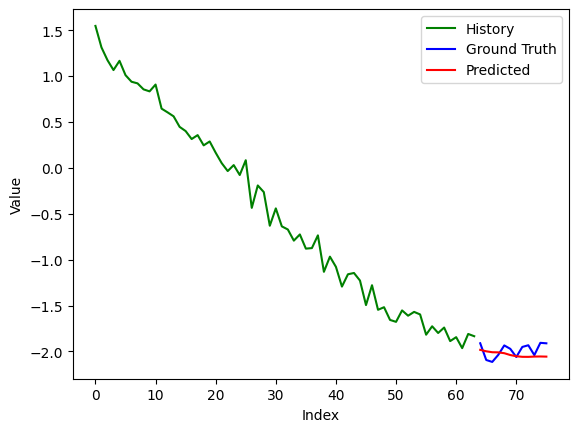

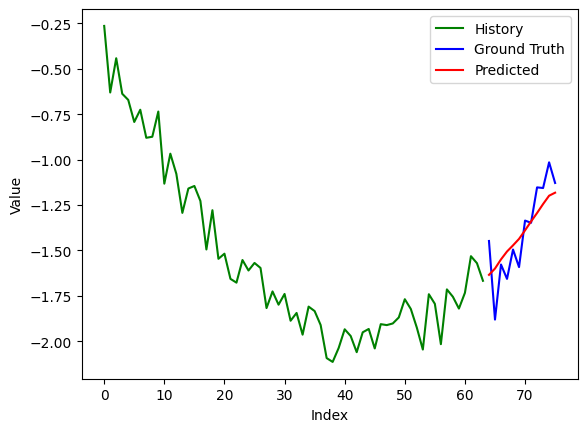

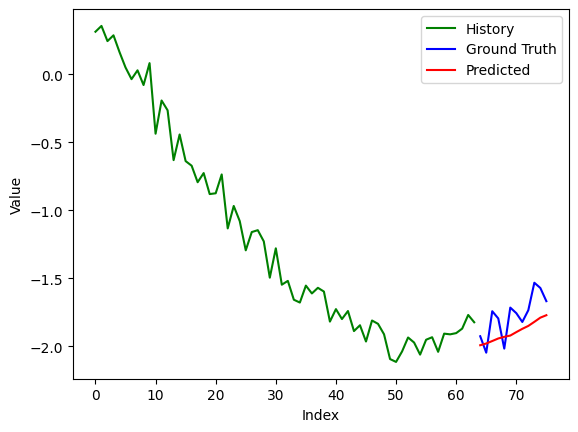

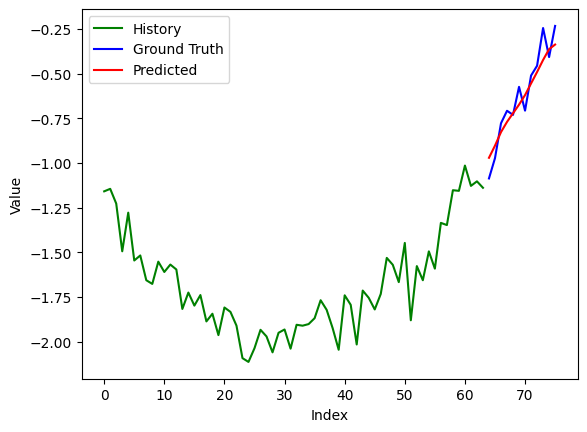

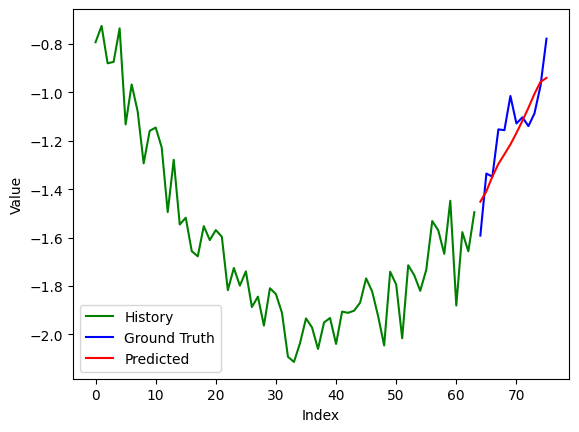

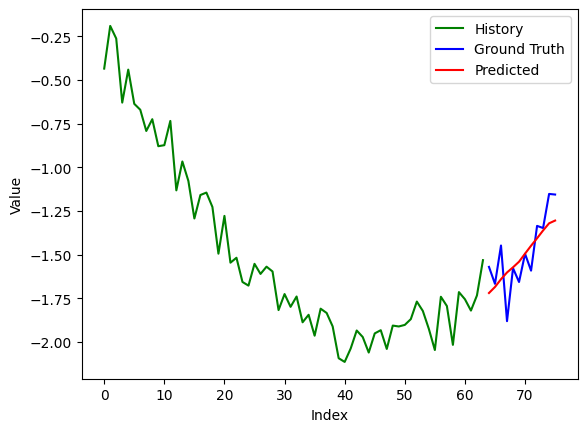

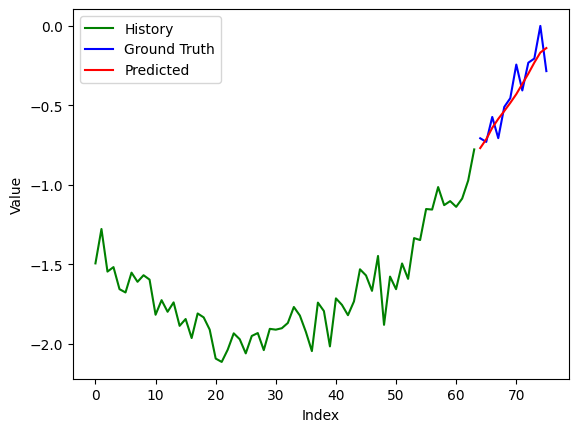

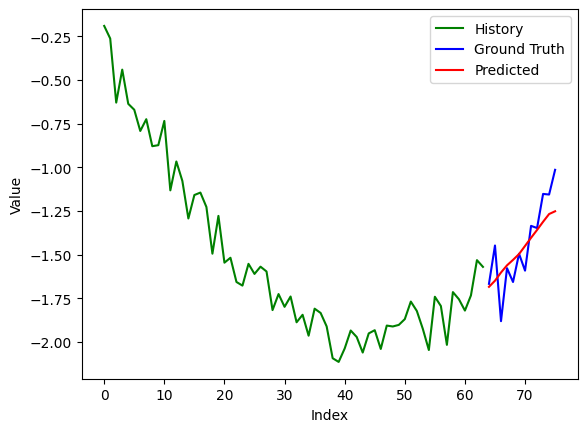

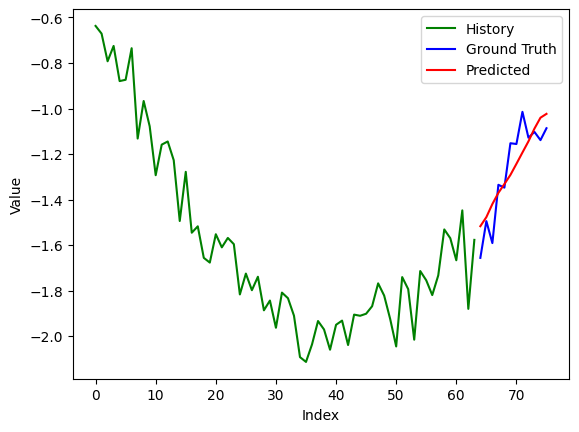

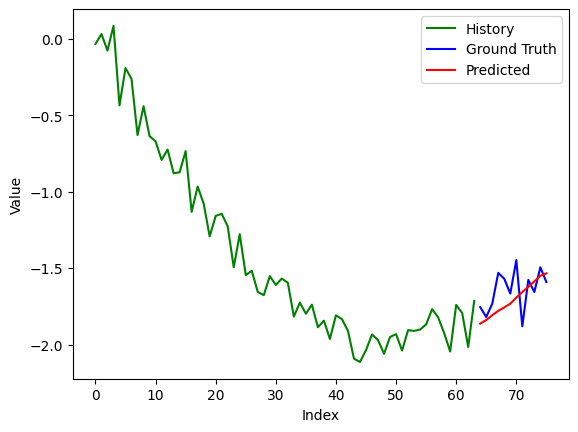

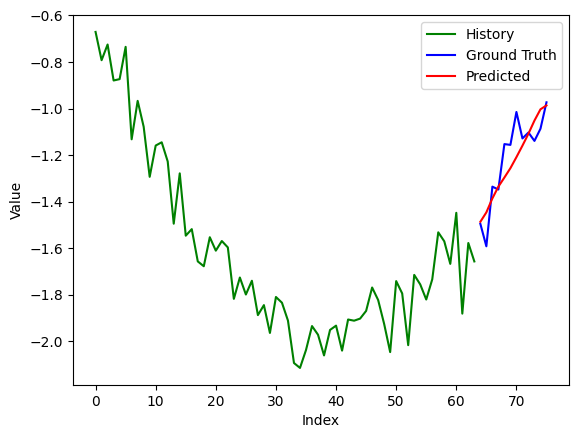

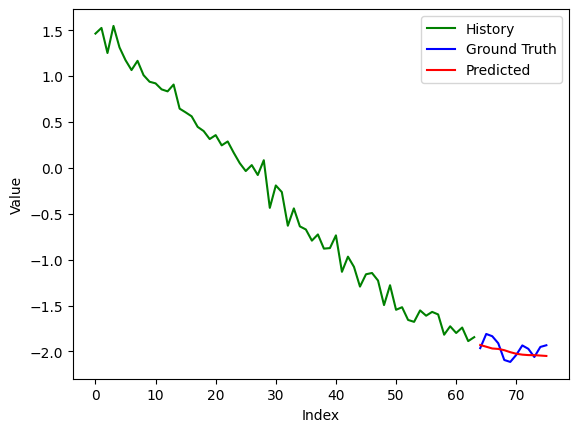

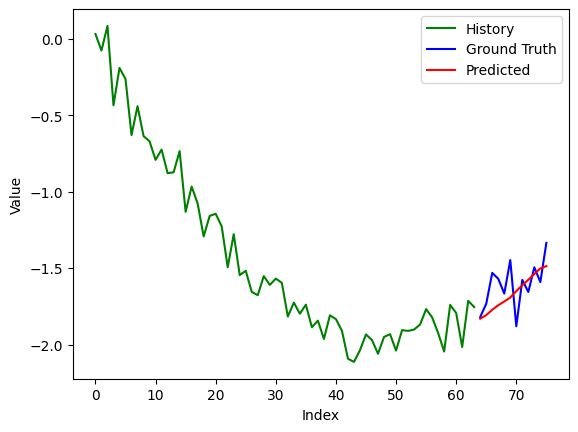

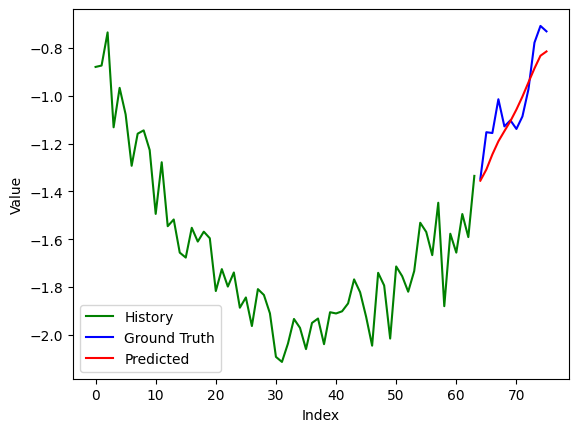

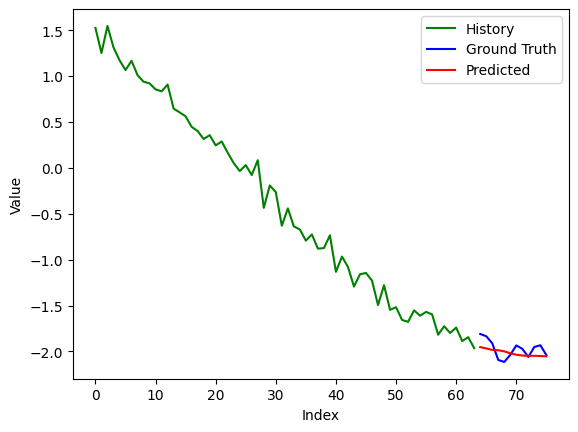

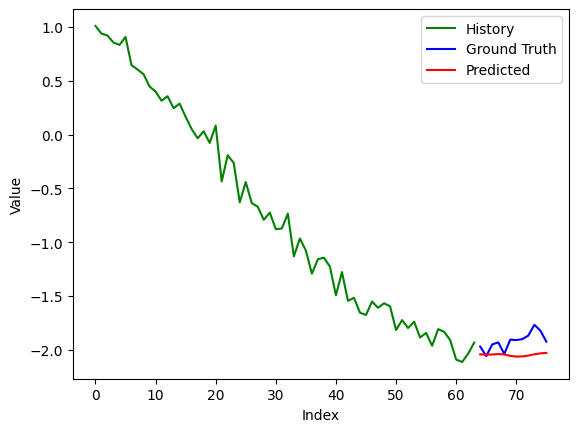

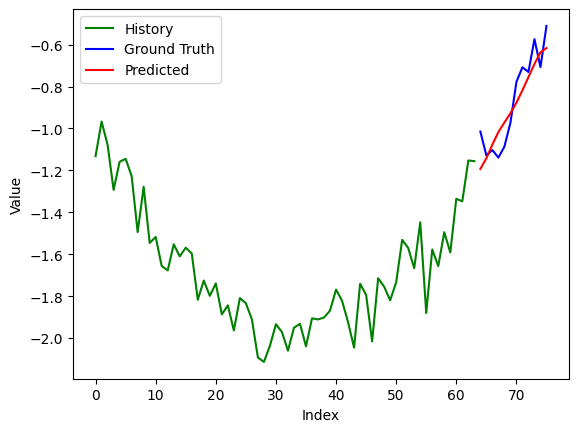

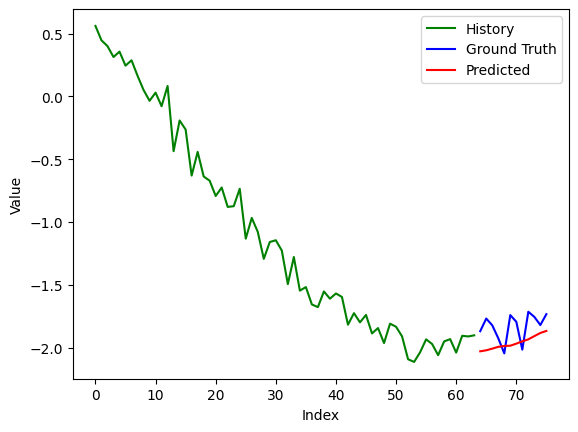

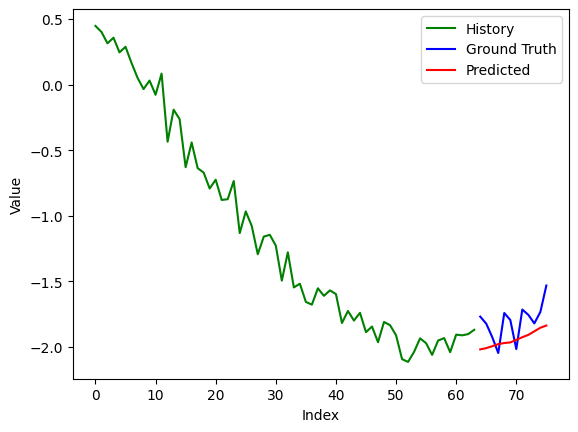

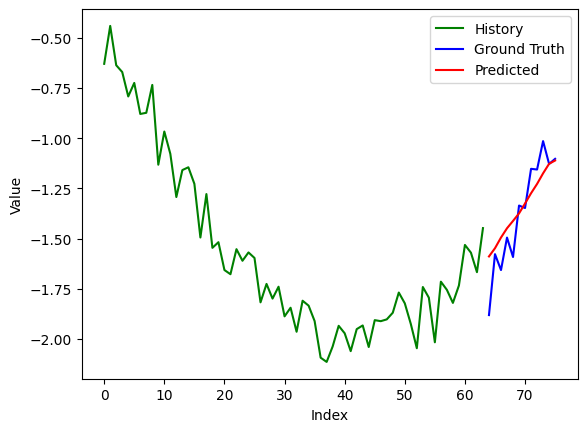

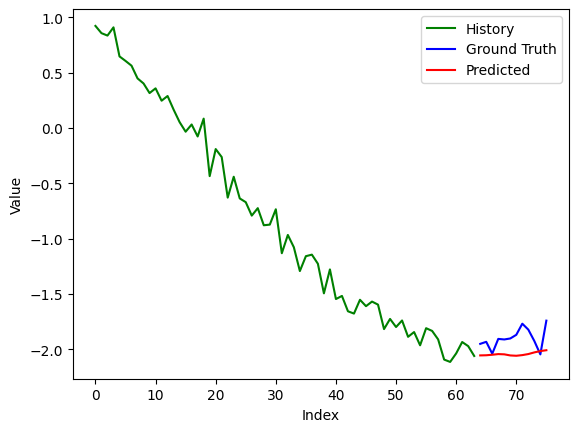

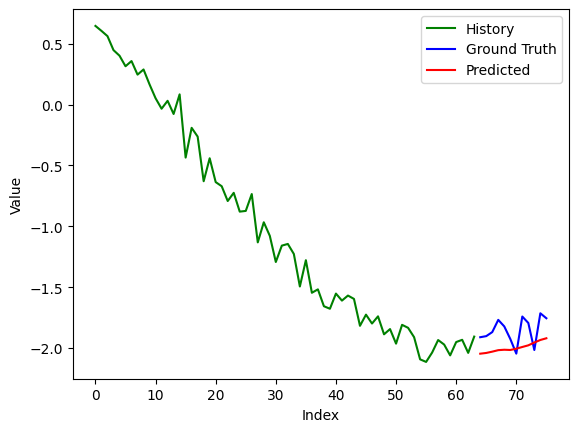

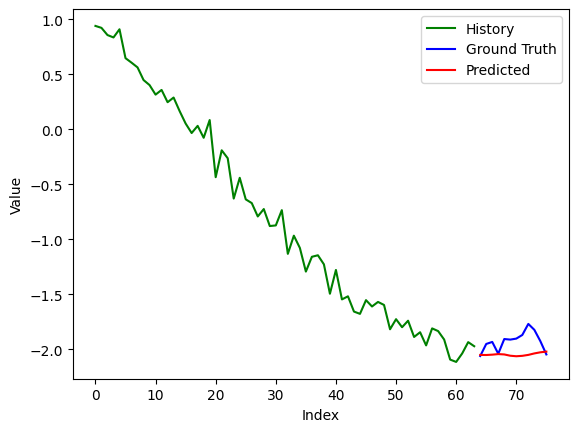

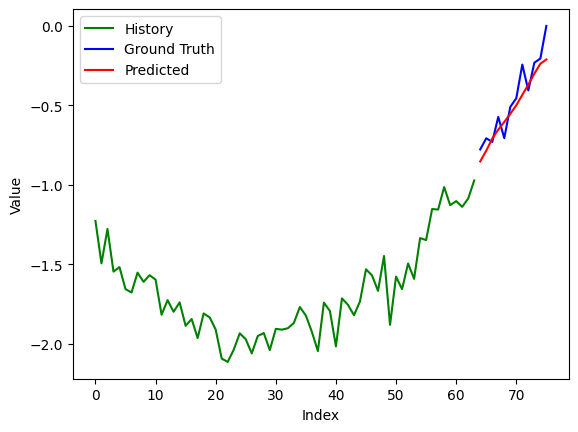

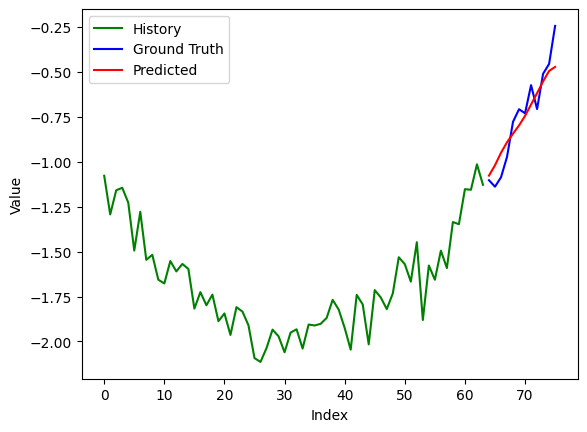

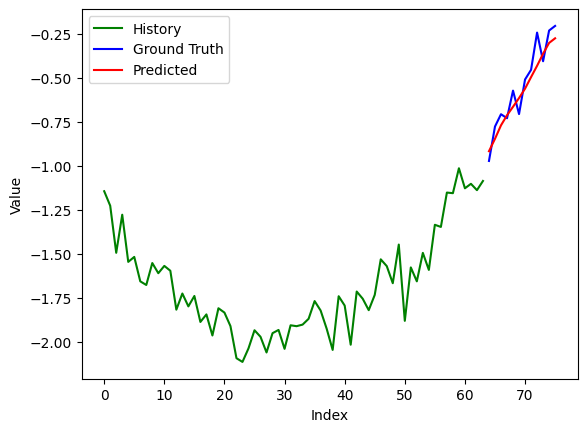

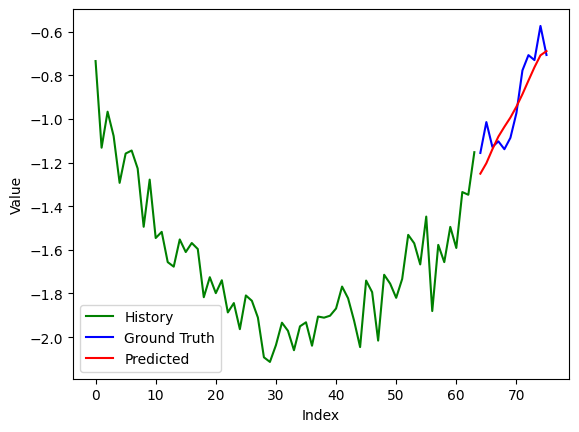

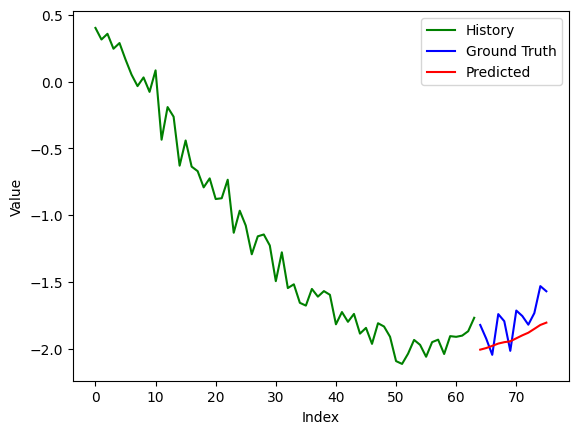

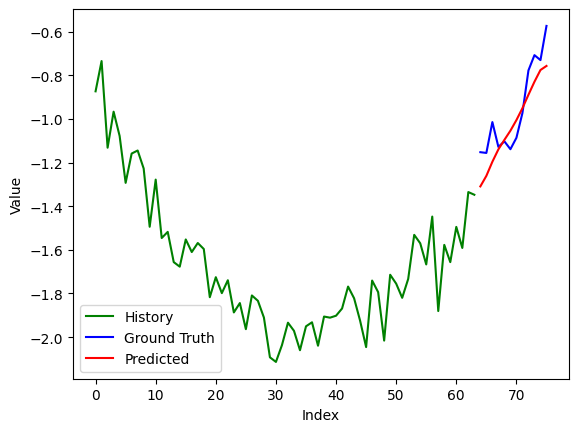

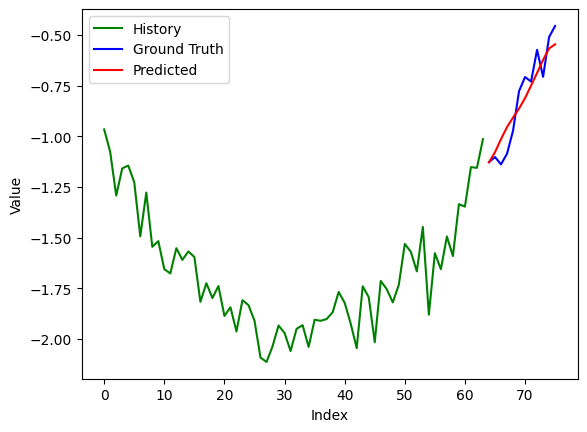

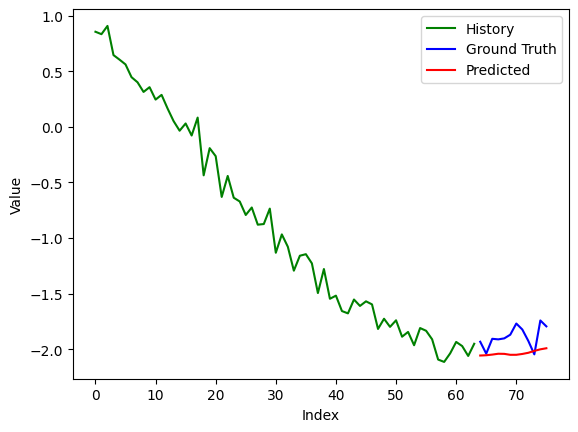

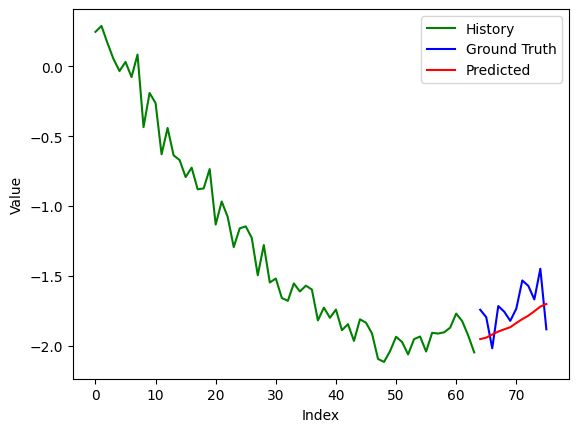

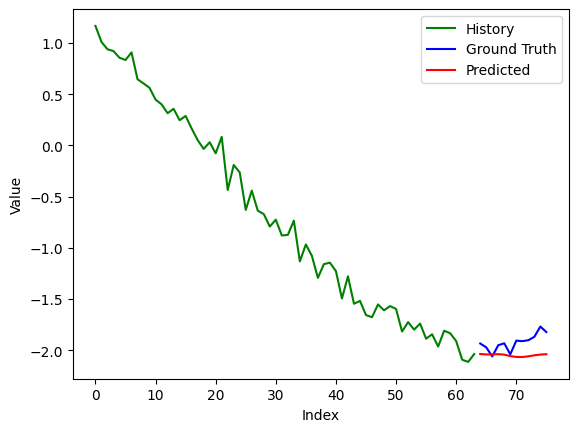

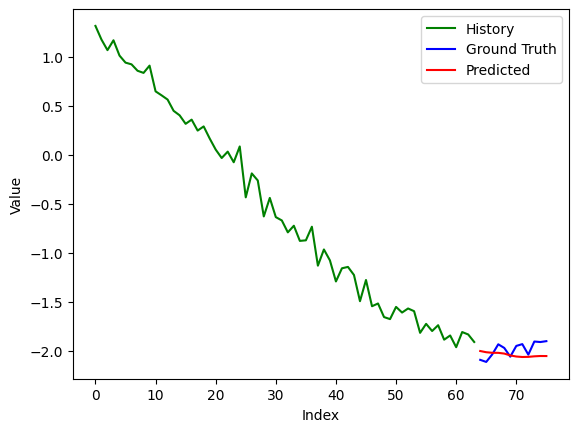

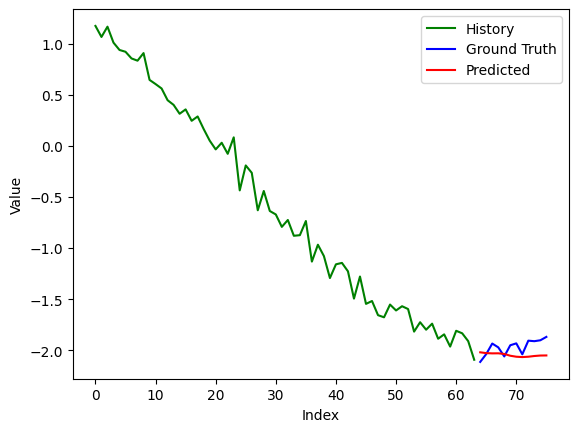

In [48]:
# Define a list of colors for the lines
colors = ['b', 'g', 'r']

counter = 0
for gt_tensor, pred_tensor, src in zip(ground_truth, predicted, src_input):
    counter += 1
    if counter < 90 or counter > 120:
        pass
    plt.figure()  # Create a new figure for each pair of tensors

    plt.plot([i for i in range(0,64)], src, label="History", color='g')

    # Plot ground truth tensor as a line with the specified color
    plt.plot([i for i in range(64,76)], gt_tensor, label="Ground Truth", color='b')

    # Plot predicted tensor as a line with the specified color
    plt.plot([i for i in range(64,76)], pred_tensor.squeeze(0), label="Predicted", color='r')

    # Add labels and legend
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()

    # Show the plot
    plt.show()
